# RL Traveling Salesman
In this notebook, we implement a reinforcement learning approach to the traveling salesman problem. It is based on Q-learning and structure2vec graph embeddings.

In [23]:
import numpy as np
import torch
import random
from collections import namedtuple
import os

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

""" Note: the code is not optimized for GPU
"""
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [24]:
from env import TSPEnv
from utils import total_distance

In [25]:
State = namedtuple('State', ('W', 'coords', 'partial_solution'))

def process_observation(obs: dict) -> State:
    """ Converts an observation dict into a State tuple."""
    W_np = obs['W']
    # normalize distances
    max_W = np.max(W_np)
    if max_W > 0:
        W_np = W_np / max_W
    W = torch.tensor(W_np, dtype=torch.float32, requires_grad=False, device=device)
    coords = obs['coords']
    partial_solution = obs['partial_solution']
    return State(W=W, coords=coords, partial_solution=partial_solution)

def state2tens(state: State) -> torch.Tensor:
    """ Creates a Pytorch tensor representing the history of visited nodes, from a (single) state tuple.
    Each node is represented by a feature vector with the following features:
    - is_visited (1/0)
    - is_first_node_in_solution (1/0)
    - is_last_node_in_solution (1/0)
    - distance_from_last_node_in_solution (float)
    - distance_from_first_node_in_solution (float)
    The output tensor has shape (nr_nodes, nr_features)
    """
    W = state.W
    solution = set(state.partial_solution)
    sol_last_node = state.partial_solution[-1] if len(state.partial_solution) > 0 else -1
    sol_first_node = state.partial_solution[0] if len(state.partial_solution) > 0 else -1
    coords = state.coords
    nr_nodes = coords.shape[0]

    xv = [[(1 if i in solution else 0),
           (1 if i == sol_first_node else 0),
           (1 if i == sol_last_node else 0),
           (W[sol_last_node, i] if sol_last_node >= 0 else 0.0),
           (W[sol_first_node, i] if sol_first_node >= 0 else 0.0),
          ] for i in range(nr_nodes)]
    
    return torch.tensor(xv, dtype=torch.float32, requires_grad=False, device=device)

In [26]:
NODE_DIM = 5  # Number of features per node in the input to the Q-network

class QNet(nn.Module):
    """ The neural net that will parameterize the function Q(s, a)

        The input is the state (containing the graph and visited nodes),
        and the output is a vector of size N containing Q(s, a) for each of the N actions a.
    """

    def __init__(self, emb_dim, T=2):
        """ emb_dim: embedding dimension p
            T: number of iterations for the graph embedding
        """
        super(QNet, self).__init__()
        self.emb_dim = emb_dim
        self.T = T
        
        # input node feature dimension
        self.node_dim = NODE_DIM
        
        # We can have an extra layer after theta_1 (for the sake of example to make the network deeper)
        nr_extra_layers_1 = 1
        
        # Build the learnable affine maps:
        self.theta1 = nn.Linear(self.node_dim, self.emb_dim, True)
        self.theta2 = nn.Linear(self.emb_dim, self.emb_dim, True)
        self.theta3 = nn.Linear(self.emb_dim, self.emb_dim, True)
        self.theta4 = nn.Linear(1, self.emb_dim, True)
        self.theta5 = nn.Linear(2*self.emb_dim, 1, True)
        self.theta6 = nn.Linear(self.emb_dim, self.emb_dim, True)
        self.theta7 = nn.Linear(self.emb_dim, self.emb_dim, True)
        
        # register extra layers so that parameters are tracked by the module
        self.theta1_extras = nn.ModuleList([nn.Linear(self.emb_dim, self.emb_dim, True) for _ in range(nr_extra_layers_1)])
        
    def forward(self, xv, Ws):
        # xv: The node features (batch_size, num_nodes, node_dim)
        # Ws: The graphs (batch_size, num_nodes, num_nodes) - distances normalized earlier
        
        num_nodes = xv.shape[1]
        batch_size = xv.shape[0]
        
        # Graph embedding
        # Convert distances into inverse-distance similarities and normalize per node.
        # This uses information from Ws (the actual distances) rather than only binary connectivity.
        W_sim = torch.where(Ws > 0, 1.0 / (Ws + 1e-6), torch.zeros_like(Ws))
        W_denom = W_sim.sum(dim=2, keepdim=True) + 1e-6
        
        # Note: initialize mu on the same device as xv
        mu = torch.zeros(batch_size, num_nodes, self.emb_dim, device=xv.device)
        s1 = self.theta1(xv)  # (batch_size, num_nodes, emb_dim)
        for layer in self.theta1_extras:
            s1 = layer(F.relu(s1))  # we apply the extra layer
        
        s3_1 = F.relu(self.theta4(Ws.unsqueeze(3)))  # (batch_size, nr_nodes, nr_nodes, emb_dim)
        s3_2 = torch.sum(s3_1, dim=1)  # (batch_size, nr_nodes, emb_dim)
        s3 = self.theta3(s3_2)  # (batch_size, nr_nodes, emb_dim)
        
        for t in range(self.T):
            # aggregate neighbor embeddings weighted by inverse-distance similarities
            weighted = (W_sim.matmul(mu)) / W_denom
            s2 = self.theta2(weighted)
            mu = F.relu(s1 + s2 + s3)
            
        # prediction
        # we repeat the global state (summed over nodes) for each node,
        # in order to concatenate it to local states later
        global_state = self.theta6(torch.sum(mu, dim=1, keepdim=True).repeat(1, num_nodes, 1))
        
        local_action = self.theta7(mu)  # (batch_dim, nr_nodes, emb_dim)
            
        out = F.relu(torch.cat([global_state, local_action], dim=2))
        return self.theta5(out).squeeze(dim=2)


In [27]:
""" See what the model returns
"""
model = QNet(3, T=1).to(device)
env = TSPEnv(num_cities=5)
obs, info = env.reset()
W = torch.tensor(obs['W'], dtype=torch.float32, device=device)
xv = torch.rand((1, W.shape[0], NODE_DIM)).to(device) # random node state
Ws = W.unsqueeze(0)

y = model(xv, Ws)
print('model output: {}'.format(y))
print(total_distance([0,1,2], W.cpu().numpy()))

model output: tensor([[-0.5436, -0.5488, -0.5456, -0.5358, -0.5440]],
       grad_fn=<SqueezeBackward1>)
0.3976329


In [28]:
class QFunction():
    def __init__(self, model, optimizer, lr_scheduler):
        self.model = model  # The actual QNet
        self.optimizer = optimizer
        self.lr_scheduler = lr_scheduler
        self.loss_fn = nn.SmoothL1Loss()
    
    def predict(self, state_tsr, W):
        # batch of 1 - only called at inference time
        with torch.no_grad():
            estimated_rewards = self.model(state_tsr.unsqueeze(0), W.unsqueeze(0))
        return estimated_rewards[0]
                
    def get_best_action(self, state_tsr, state):
        """ Computes the best (greedy) action to take from a given state
            Returns a tuple containing the ID of the next node and the corresponding estimated reward
        """
        W = state.W
        estimated_rewards = self.predict(state_tsr, W)  # size (nr_nodes,)
        sorted_reward_idx = estimated_rewards.argsort(descending=True)
        
        solution = state.partial_solution
        
        already_in = set(solution)
        for idx in sorted_reward_idx.tolist():
            if (len(solution) == 0 or W[solution[-1], idx] > 0) and idx not in already_in:
                return idx, estimated_rewards[idx].item()
        
    def batch_update(self, states_tsrs, Ws, actions, targets):
        """ Take a gradient step using the loss computed on a batch of (states, Ws, actions, targets)
        
            states_tsrs: list of (single) state tensors
            Ws: list of W tensors
            actions: list of actions taken
            targets: list of targets (resulting estimated rewards after taking the actions)
        """        
        Ws_tsr = torch.stack(Ws).to(device)
        xv = torch.stack(states_tsrs).to(device)
        self.optimizer.zero_grad()
        
        # the rewards estimated by Q for the given actions
        estimated_rewards = self.model(xv, Ws_tsr)[range(len(actions)), actions]
        
        # Ensure targets are of type float32
        targets_tensor = torch.tensor(targets, dtype=torch.float32, device=device)
        
        loss = self.loss_fn(estimated_rewards, targets_tensor)
        loss_val = loss.item()
        
        loss.backward()
        # gradient clipping to avoid exploding gradients
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
        self.optimizer.step()        
        self.lr_scheduler.step()
        
        return loss_val


## Define experiences & memory
We'll now a tuple representing an experience, and the memory that contains such experiences. An experience is composed of a (state, action) tuple, and the corresponding "next state" and reward. The "next state" can be N step after the "state" in the case of N-step Q-learning. In experiences, we save states both in their tuple and tensor representations, in order to avoid computing these somewhat expensive translations after the experience has been stored.

The Memory class implements a memory of limited size.

In [29]:
# Note: we store state tensors in experience to compute these tensors only once later on
Experience = namedtuple('Experience', ('state', 'state_tsr', 'action', 'reward', 'next_state', 'next_state_tsr'))

class Memory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        self.nr_inserts = 0
        
    def remember(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = experience
        self.position = (self.position + 1) % self.capacity
        self.nr_inserts += 1
        
    def sample_batch(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return min(self.nr_inserts, self.capacity)

## Training Code

### Hyperparameters

In [30]:
SEED = 1  # A seed for the random number generator

# Graph
NR_NODES = 10  # Number of nodes N
EMBEDDING_DIMENSIONS = 5  # Embedding dimension D
EMBEDDING_ITERATIONS_T = 1  # Number of embedding iterations T (small increase)

# Learning
NR_EPISODES = 4001
MEMORY_CAPACITY = 10000
N_STEP_QL = 2  # Number of steps (n) in n-step Q-learning to wait before computing target reward estimate
BATCH_SIZE = 16

GAMMA = 0.9
INIT_LR = 5e-3
LR_DECAY_RATE = 1. - 2e-5  # learning rate decay

MIN_EPSILON = 0.1
EPSILON_DECAY_RATE = 6e-4  # epsilon decay

FOLDER_NAME = './models'  # where to checkpoint the best models

TAU = 0.005  # interpolation factor for soft updates (typical: 0.001-0.01)


In [31]:
def init_model(fname=None):
    """ Create a new model. If fname is defined, load the model from the specified file.
    """
    Q_net = QNet(EMBEDDING_DIMENSIONS, T=EMBEDDING_ITERATIONS_T).to(device)
    # target network is a copy of online network used to compute stable targets
    target_net = QNet(EMBEDDING_DIMENSIONS, T=EMBEDDING_ITERATIONS_T).to(device)
    target_net.load_state_dict(Q_net.state_dict())

    optimizer = optim.Adam(Q_net.parameters(), lr=INIT_LR)
    lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=LR_DECAY_RATE)
    
    if fname is not None:
        # load checkpoint (contains at least 'model')
        checkpoint = torch.load(fname, weights_only=False)
        Q_net.load_state_dict(checkpoint['model'])
        # if checkpoint contains a target model, load it; else replicate online weights
        if 'target_model' in checkpoint:
            target_net.load_state_dict(checkpoint['target_model'])
        else:
            target_net.load_state_dict(checkpoint['model'])
        if 'optimizer' in checkpoint:
            optimizer.load_state_dict(checkpoint['optimizer'])
        if 'lr_scheduler' in checkpoint:
            lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
    
    Q_func = QFunction(Q_net, optimizer, lr_scheduler)
    return Q_func, Q_net, target_net, optimizer, lr_scheduler


def checkpoint_model(model, optimizer, lr_scheduler, loss, 
                     episode, avg_length, target_model=None):
    if not os.path.exists(FOLDER_NAME):
        os.makedirs(FOLDER_NAME)
    
    fname = os.path.join(FOLDER_NAME, 'ep_{}'.format(episode))
    fname += '_length_{}'.format(avg_length)
    fname += '.tar'
    
    to_save = {
        'episode': episode,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'lr_scheduler': lr_scheduler.state_dict(),
        'loss': loss,
        'avg_length': avg_length
    }
    if target_model is not None:
        to_save['target_model'] = target_model.state_dict()

    torch.save(to_save, fname)


# Soft update helper for target network (Polyak averaging)
def soft_update(target_net, online_net, tau=0.005):
    """Soft update: target = tau*online + (1-tau)*target (in-place)."""
    with torch.no_grad():
        for tgt_param, src_param in zip(target_net.parameters(), online_net.parameters()):
            tgt_param.data.copy_(tau * src_param.data + (1.0 - tau) * tgt_param.data)


### Training Loop

In [32]:
def is_state_final(state: State) -> bool:
    """ Checks whether the given state is final (i.e., all nodes have been visited)
    """
    return len(state.partial_solution) == state.W.shape[0]

In [33]:
# seed everything for reproducible results first:
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Initialize environment
env = TSPEnv(num_cities=NR_NODES)

# Create module, optimizer, LR scheduler, target network, and Q-function
Q_func, Q_net, target_net, optimizer, lr_scheduler = init_model()

# Create memory
memory = Memory(MEMORY_CAPACITY)

# Storing metrics about training:
found_solutions = dict()  # episode --> (coords, W, solution)
losses = []
path_lengths = []

# keep track of median path length for model checkpointing
current_min_med_length = float('inf')

for episode in range(NR_EPISODES):
    # sample a new random graph
    observation, info = env.reset()
    coords, W, solution = observation['coords'], observation['W'], observation['partial_solution']
    
    # current state (tuple and tensor)
    current_state = process_observation(observation)
    current_state_tsr = state2tens(current_state)
    
    # Keep track of some variables for insertion in replay memory:
    states = [current_state]
    states_tsrs = [current_state_tsr]  # we also keep the state tensors here (for efficiency)
    rewards = []
    actions = []
    
    # current value of epsilon
    epsilon = max(MIN_EPSILON, (1-EPSILON_DECAY_RATE)**episode)
    
    nr_explores = 0
    t = -1

    done = False
    while not done:
        t += 1  # time step of this episode
        
        if epsilon >= random.random():
            # explore
            next_node = env.sample_random_action()
            nr_explores += 1
        else:
            # exploit
            next_node, est_reward = Q_func.get_best_action(current_state_tsr, current_state)
            if episode % 50 == 0:
                print('Ep {} | next est reward: {}'.format(episode, est_reward))
        
        # take action and observe next state
        observation, reward, terminated, truncated, info = env.step(next_node)
        done = terminated or truncated
        
        next_state = process_observation(observation)
        next_state_tsr = state2tens(next_state)
        
        # store rewards and states obtained along this episode:
        states.append(next_state)
        states_tsrs.append(next_state_tsr)
        rewards.append(reward)
        actions.append(next_node)
        
        # store our experience in memory, using n-step Q-learning:
        if len(solution) >= N_STEP_QL:
            memory.remember(Experience(state=states[-N_STEP_QL],
                                       state_tsr=states_tsrs[-N_STEP_QL],
                                       action=actions[-N_STEP_QL],
                                       reward=sum(rewards[-N_STEP_QL:]),
                                       next_state=next_state,
                                       next_state_tsr=next_state_tsr))
            
        if is_state_final(next_state):
            for n in range(1, N_STEP_QL):
                memory.remember(Experience(state=states[-n],
                                           state_tsr=states_tsrs[-n], 
                                           action=actions[-n], 
                                           reward=sum(rewards[-n:]), 
                                           next_state=next_state,
                                           next_state_tsr=next_state_tsr))
        
        # update state and current solution
        current_state = next_state
        current_state_tsr = next_state_tsr
        solution = next_state.partial_solution
        
        # take a gradient step
        loss = None
        if len(memory) >= BATCH_SIZE and len(memory) >= 2000:
            experiences = memory.sample_batch(BATCH_SIZE)
            
            batch_states_tsrs = [e.state_tsr for e in experiences]
            batch_Ws = [e.state.W for e in experiences]
            batch_actions = [e.action for e in experiences]
            batch_targets = []
            
            for i, experience in enumerate(experiences):
                target = experience.reward
                if not is_state_final(experience.next_state):
                    # Double Q-learning target computation:
                    # 1) use online Q_net to select best next action
                    # 2) use target_net to evaluate that action
                    with torch.no_grad():
                        q_online_next = Q_net(experience.next_state_tsr.unsqueeze(0), experience.next_state.W.unsqueeze(0))[0]
                        best_idx = int(q_online_next.argmax().item())
                        q_target_next = target_net(experience.next_state_tsr.unsqueeze(0), experience.next_state.W.unsqueeze(0))[0]
                        best_reward = float(q_target_next[best_idx].item())
                    target += GAMMA * best_reward
                batch_targets.append(target)
                
            # print('batch targets: {}'.format(batch_targets))
            loss = Q_func.batch_update(batch_states_tsrs, batch_Ws, batch_actions, batch_targets)
            losses.append(loss)

            # soft-update target network
            soft_update(target_net, Q_net, tau=TAU)

            """ Save model when we reach a new low average path length
            """
            med_length = np.median(path_lengths[-100:])
            if med_length < current_min_med_length:
                current_min_med_length = med_length
                checkpoint_model(Q_net, optimizer, lr_scheduler, loss, episode, med_length, target_model=target_net)
                
    length = total_distance(solution, W)
    path_lengths.append(length)

    if episode % 10 == 0:
        print('Ep %d. Loss = %.3f / median length = %.3f / last = %.4f / epsilon = %.4f / lr = %.4f' % (
            episode, (-1 if loss is None else loss), np.median(path_lengths[-50:]), length, epsilon,
            Q_func.optimizer.param_groups[0]['lr']))
        found_solutions[episode] = (W.copy(), coords.copy(), [n for n in solution])


Ep 0. Loss = -1.000 / median length = 4.391 / last = 4.3909 / epsilon = 1.0000 / lr = 0.0050
Ep 10. Loss = -1.000 / median length = 5.094 / last = 5.6983 / epsilon = 0.9940 / lr = 0.0050
Ep 20. Loss = -1.000 / median length = 5.216 / last = 6.8767 / epsilon = 0.9881 / lr = 0.0050
Ep 30. Loss = -1.000 / median length = 5.189 / last = 4.6866 / epsilon = 0.9822 / lr = 0.0050
Ep 40. Loss = -1.000 / median length = 5.191 / last = 5.1911 / epsilon = 0.9763 / lr = 0.0050
Ep 50. Loss = -1.000 / median length = 5.097 / last = 4.7065 / epsilon = 0.9704 / lr = 0.0050
Ep 60. Loss = -1.000 / median length = 5.207 / last = 6.2009 / epsilon = 0.9646 / lr = 0.0050
Ep 70. Loss = -1.000 / median length = 5.246 / last = 5.7044 / epsilon = 0.9589 / lr = 0.0050
Ep 80. Loss = -1.000 / median length = 5.276 / last = 4.8767 / epsilon = 0.9531 / lr = 0.0050
Ep 90. Loss = -1.000 / median length = 5.276 / last = 4.7592 / epsilon = 0.9474 / lr = 0.0050
Ep 100. Loss = -1.000 / median length = 5.276 / last = 5.4056

### Inspect Training Metrics

Text(0.5, 0, 'episode')

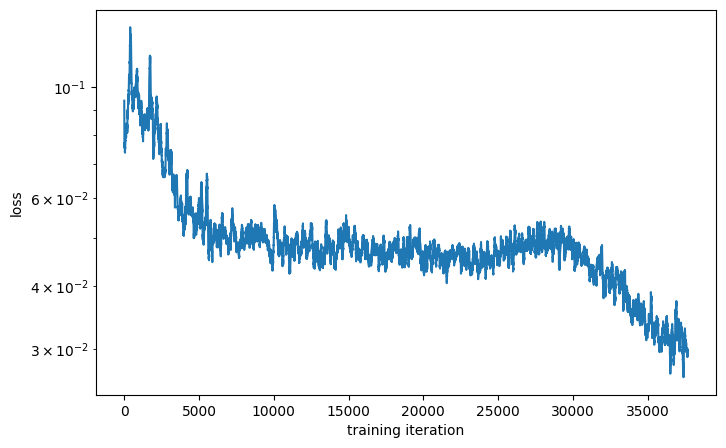

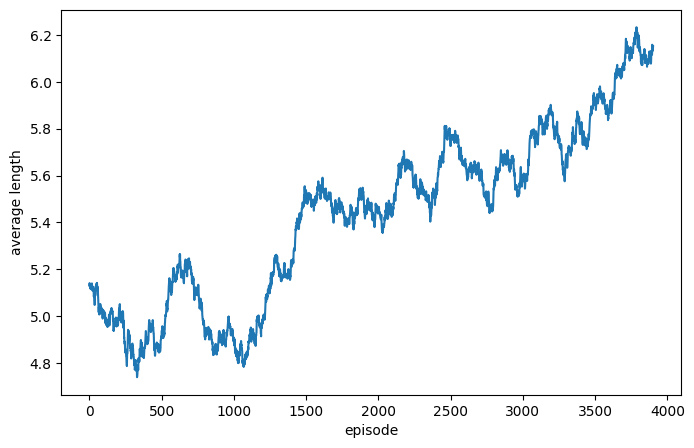

In [34]:
def _moving_avg(x, N=10):
    return np.convolve(np.array(x), np.ones((N,))/N, mode='valid')

plt.figure(figsize=(8,5))
plt.semilogy(_moving_avg(losses, 100))
plt.ylabel('loss')
plt.xlabel('training iteration')

plt.figure(figsize=(8,5))
plt.plot(_moving_avg(path_lengths, 100))
plt.ylabel('average length')
plt.xlabel('episode')

In [35]:
""" Get file with smallest distance
"""
all_lengths_fnames = [f for f in os.listdir(FOLDER_NAME) if f.endswith('.tar')]
shortest_fname = sorted(all_lengths_fnames, key=lambda s: float(s.split('.tar')[0].split('_')[-1]))[0]
print('shortest avg length found: {}'.format(shortest_fname.split('.tar')[0].split('_')[-1]))

""" Load checkpoint
"""
Q_func, Q_net, target_net, optimizer, lr_scheduler = init_model(os.path.join(FOLDER_NAME, shortest_fname))

""" A function to plot solutions
"""
def plot_solution(coords, mat, solution):
    plt.scatter(coords[:,0], coords[:,1])
    n = len(coords)
    
    for idx in range(n-1):
        i, next_i = solution[idx], solution[idx+1]
        plt.plot([coords[i, 0], coords[next_i, 0]], [coords[i, 1], coords[next_i, 1]], 'k', lw=2, alpha=0.8)
    
    i, next_i = solution[-1], solution[0]
    plt.plot([coords[i, 0], coords[next_i, 0]], [coords[i, 1], coords[next_i, 1]], 'k', lw=2, alpha=0.8)
    plt.plot(coords[solution[0], 0], coords[solution[0], 1], 'x', markersize=10)



shortest avg length found: 4.652579307556152


time taken: 0.0195 seconds
time taken: 0.0146 seconds
time taken: 0.0142 seconds
time taken: 0.0135 seconds
time taken: 0.0155 seconds
time taken: 0.0141 seconds
time taken: 0.0133 seconds
time taken: 0.0142 seconds
time taken: 0.0135 seconds
time taken: 0.0129 seconds


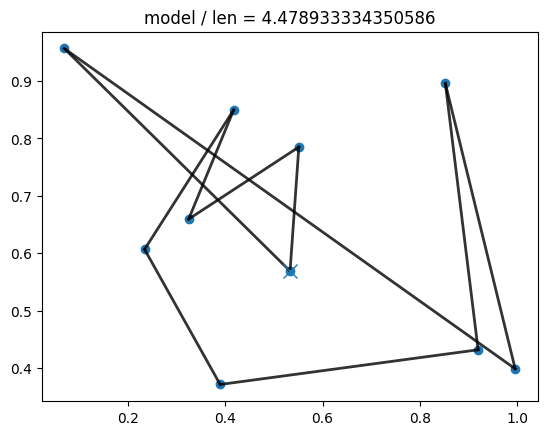

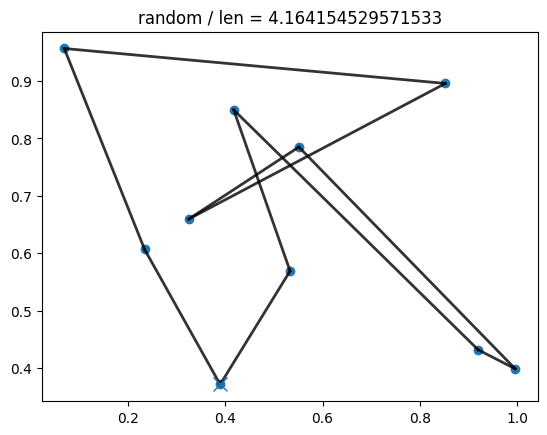

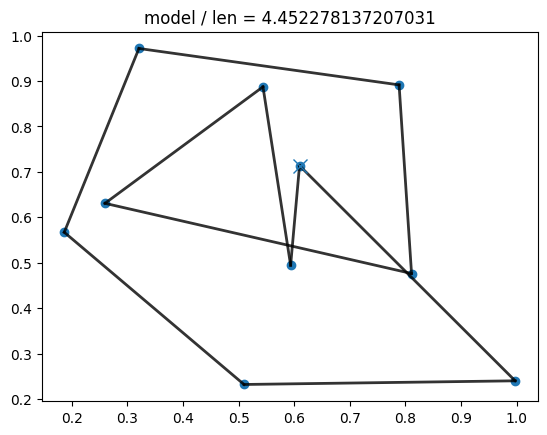

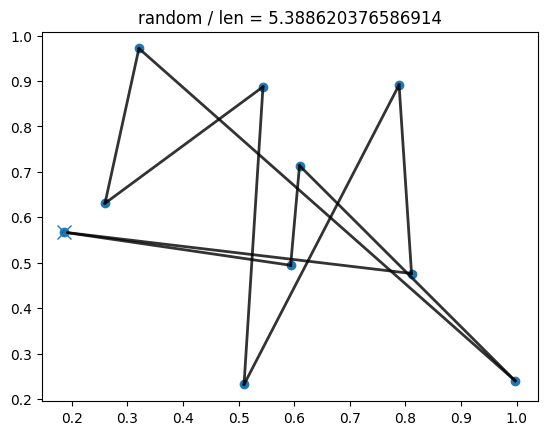

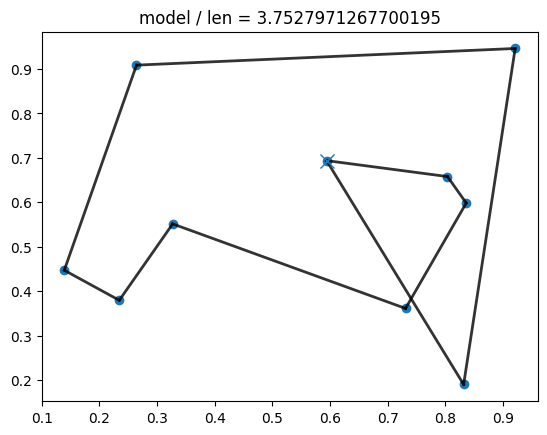

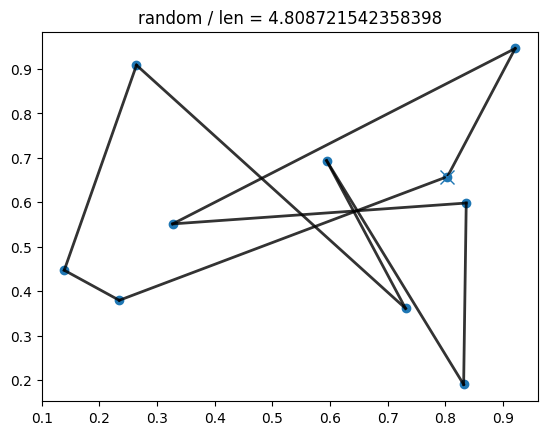

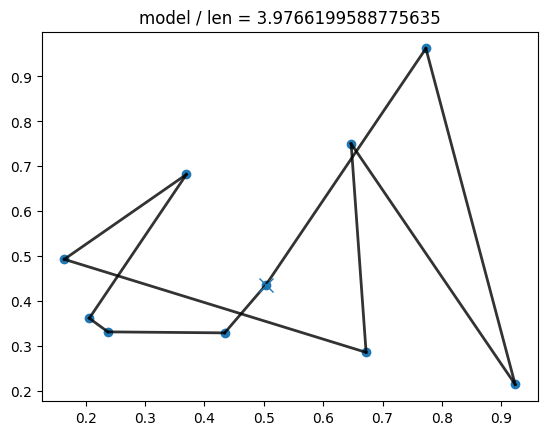

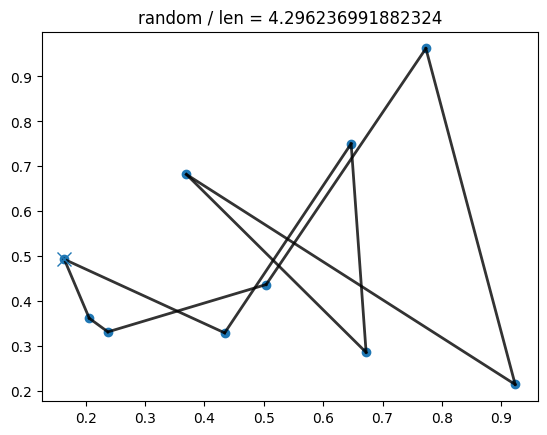

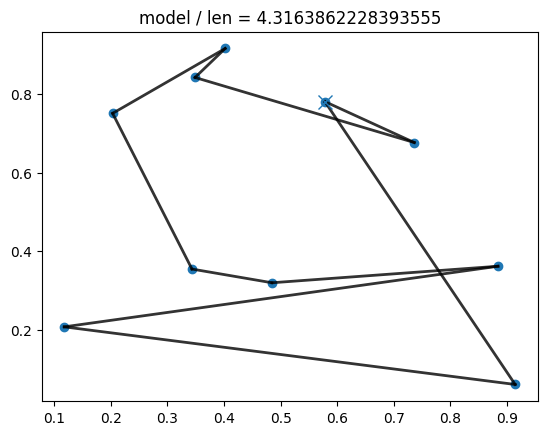

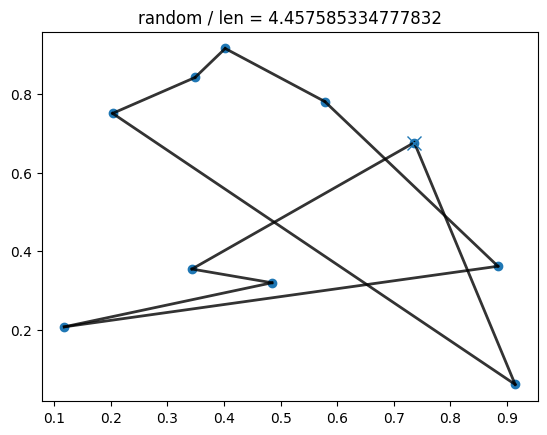

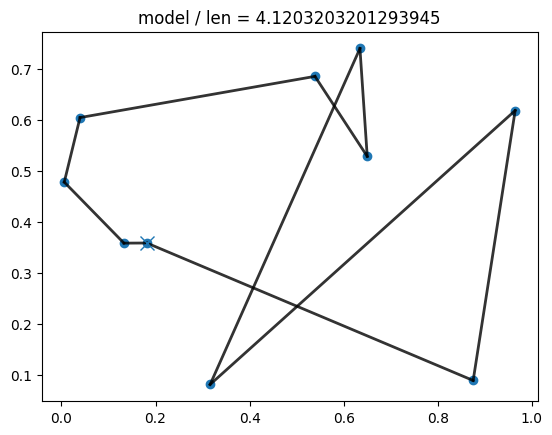

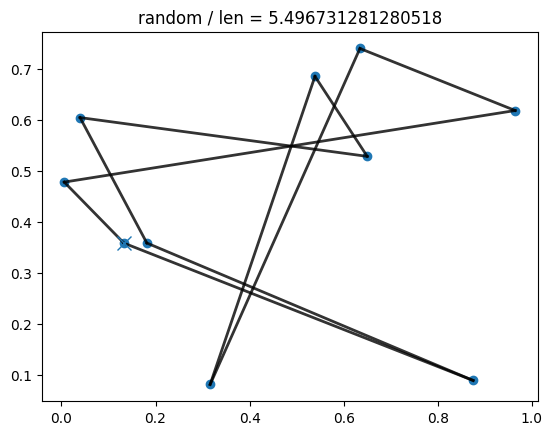

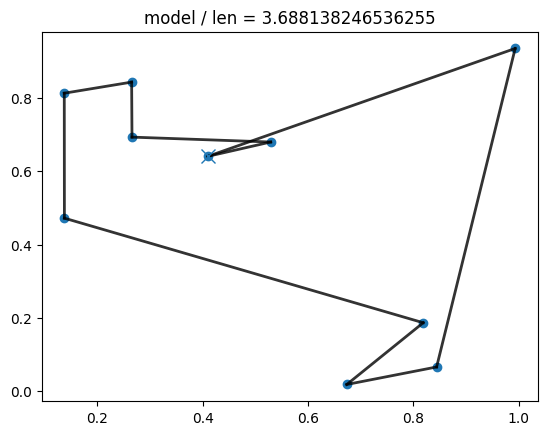

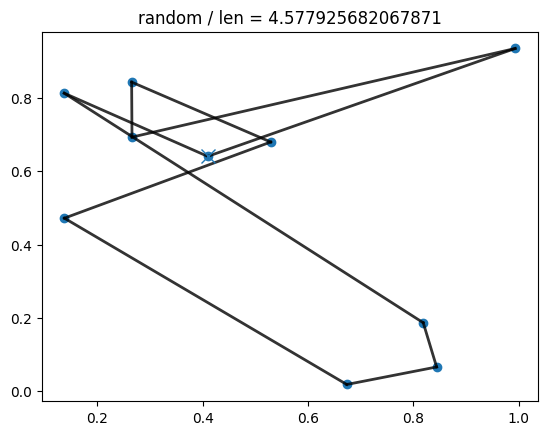

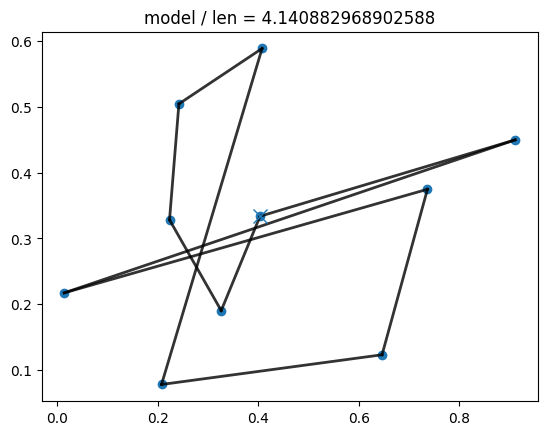

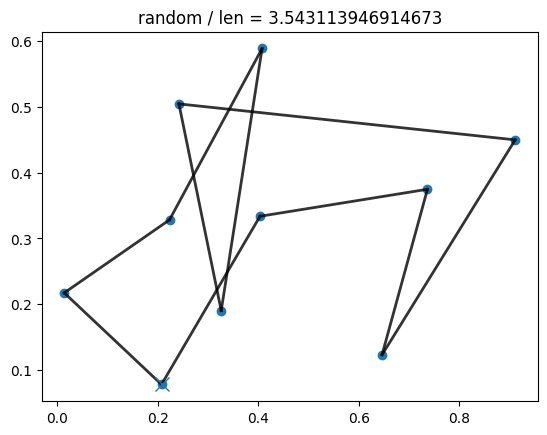

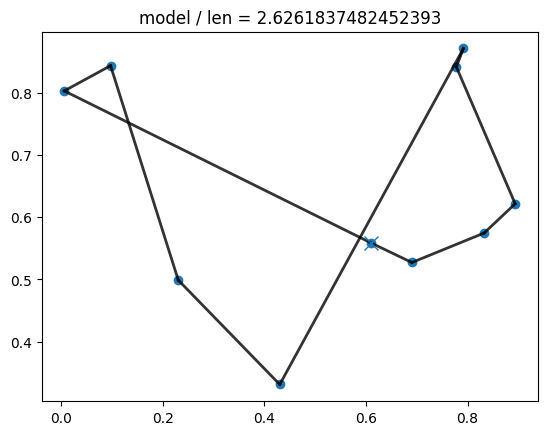

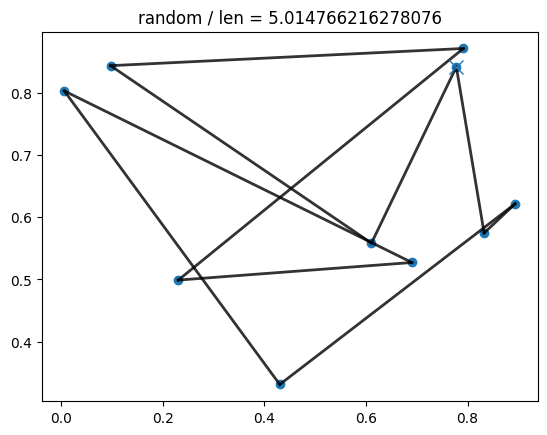

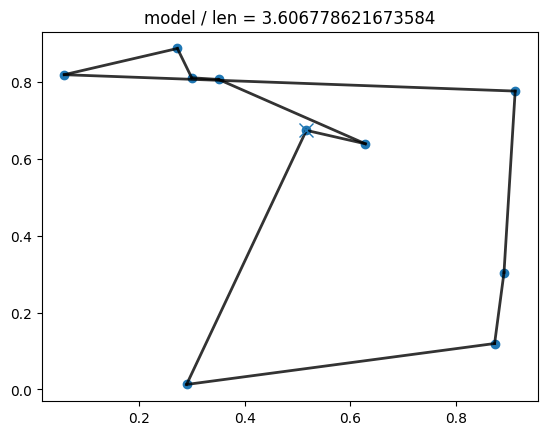

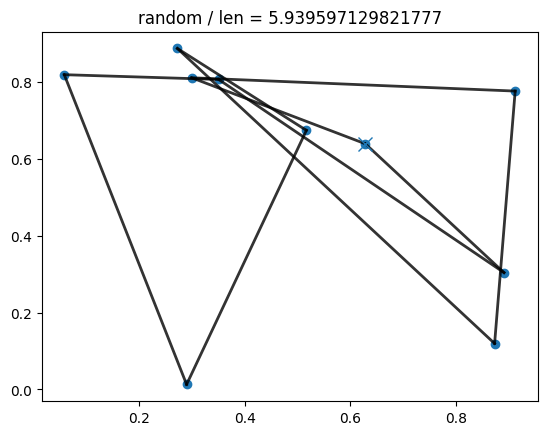

In [36]:
import time

""" Generate example solutions
"""
NR_NODES = 10
env = TSPEnv(num_cities=NR_NODES)

for sample in range(10):
    observation, info = env.reset()
    coords, W = observation['coords'], observation['W']

    start_time = time.time()
    
    current_state = process_observation(observation)
    current_state_tsr = state2tens(current_state)

    done = False
    
    while not done:
        next_node, est_reward = Q_func.get_best_action(current_state_tsr, 
                                                       current_state)
        
        
        observation, reward, terminated, truncated, info = env.step(next_node)
        done = terminated or truncated
        current_state = process_observation(observation)
        current_state_tsr = state2tens(current_state)

    print("time taken: {:.4f} seconds".format(time.time() - start_time))
        
    plt.figure()
    plot_solution(coords, W, current_state.partial_solution)
    plt.title('model / len = {}'.format(total_distance(current_state.partial_solution, W)))
    
    # for comparison, plot a random solution
    plt.figure()
    random_solution = list(range(NR_NODES))
    plot_solution(coords, W, random_solution)
    plt.title('random / len = {}'.format(total_distance(random_solution, W)))